In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import os
import sys
import subprocess
import pandas as pd
#import seaborn as sb

from scipy import stats

import matplotlib.backends.backend_pdf
from datetime import datetime

#Fecha actual
ahora = str(datetime.now()).split(' ') 
fecha = ahora[0] 

print('Última modificacion: %s' %fecha)

lw=2
fz=15

Última modificacion: 2021-09-28


## Camino de los datos:

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b327_data/Amplitude_Candidates/Amplitude_candidates_b327.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b327_data/eta_Candidates/eta_Candidates_b327.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b328_data/Amplitude_Candidates/Amplitude_candidates_b328.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b328_data/eta_Candidates/eta_Candidates_b328.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b329_data/Amplitude_Candidates/Amplitude_candidates_b329.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b329_data/eta_Candidates/eta_Candidates_b329.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b341_data/Amplitude_Candidates/Amplitude_candidates_b341.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b341_data/eta_Candidates/eta_Candidates_b341.cat

/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b342_data/Amplitude_Candidates/Amplitude_candidates_b342.cat
/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/b342_data/eta_Candidates/eta_Candidates_b342.cat

/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/b343_data/Amplitude_Candidates/Amplitude_candidates_b343.cat
/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/b343_data/eta_Candidates/eta_Candidates_b343.cat

Primero, escribiremos lo que quiero lograr con esto:

- [x] Visualizar los datos de las regiones de formación estelar 3 que hemos conseguido.
- [x] Unir las series de tiempo que están superpuestas.
- [x] Crear el plot de amplitud
- [x] calcular los indices con incerteza usando bootstrap y comparar en regresion lineal
- [ ] Colores con catálogo VIVA.
- [ ] Hacer un proceso para crear un catálogo de estrellas periodicas encontradas e identificadas con IP metric.
- [ ] Juntar estrellas variables GLS con las IP usando los mismos índices y sus incertezas.
- [ ] FIN


## Camino del catálogo generado en TopCat:
/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/Irregular_catalog_SFR3_21Sep2021.csv

## Catalogo de fuentes que están superpuestos en diferentes tiles:
/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/Irregular_catalog_SFR3_superposed_21Sep2021.csv


In [2]:
def ReadCords(Ra,Dec,gal=True,Ndecimales=7):
    """
    Devuelve las coordenadas 2000 en longuitudo y latitud galactica.
    """
    
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    import numpy as np

    if gal == True:
        c = SkyCoord(np.array(Ra)*u.degree, np.array(Dec)*u.degree)
        cc = c.galactic
        l_aux = cc.l.degree
        b_aux = cc.b.degree
        
        l = np.array([round(l_aux[i],Ndecimales) for i in range(len(l_aux))])
        b = np.array([round(b_aux[i],Ndecimales) for i in range(len(b_aux))])
        return l,b
    
    return Ra,Dec

def nbins(X):
    """
    Taken from http://toyoizumilab.brain.riken.jp/hideaki/res/histogram.html
    """
    import numpy as np

    x_max = np.max(X)
    x_min = np.min(X)
    N_MIN = 5  #Minimum number of bins (integer)
               #N_MIN must be more than 1 (N_MIN > 1).
    N_MAX = 100  #Maximum number of bins (integer)
    N = range(N_MIN,N_MAX) # #of Bins
    N = np.array(N)
    D = (x_max-x_min)/N    #Bin size vector
    C = np.zeros((len(D),1))

    #Computation of the cost function
    for i in range(np.size(N)):
        edges = np.linspace(x_min,x_max,N[i]+1) # Bin edges
        ki = np.histogram(X,edges) # Count # of events in bins
        ki = ki[0]    
        k = np.mean(ki) #Mean of event count
        v = sum((ki-k)**2)/N[i] #Variance of event count
        C[i] = (2*k-v)/((D[i])**2) #The cost Function
    #Optimal Bin Size Selection
    cmin = min(C)
    idx  = np.where(C==cmin)
    
    #print idx

    try:
        idx = int(idx[0])
    except TypeError:
        idx = 10
        return 10

    #print idx

    optD = D[idx]

    edges = np.linspace(x_min,x_max,N[idx]+1)
    #plt.hist(X,edges, normed=True)
    #title(u"Histogram")
    #ylabel(u"Frequency")
    #xlabel(u"Value")
    return len(edges)-1

def DKs_bootstrap(mag,iteraciones=1000,porcentaje=0.5,show_hist=False):
    """
    Realiza la medición de la amplitud, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = max(MAG)-min(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

def MeanKs_bootstrap(mag,iteraciones=1000,porcentaje=0.1,show_hist=False):
    """
    Realiza la medición de la magnitud media, y estima el error usando bootstrap.
    Entrada:
    iteraciones: Repeticiones del bootstrap.
    porcentaje: % de datos que se retiran de la muestra para hacer el cálculo.
    retorna; MeanKs, error
    """
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    N = len(mag)-1

    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample toma N2-porcent numeros random de mag, así creamos nuestra muestra por bootstrap.
        MAG = sample(list(mag),N-porcent)
        bootstrap[i] = np.mean(MAG)

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std


In [230]:
def bootstrap_index(mjd,mag,err,funcion='eta',iteraciones=1000,porcentaje=0.1,show_hist=False):
    
    '''
    Funcion que calcula un indice de variabilidad usando bootstrap y generando un invervalo de incerteza
    Los indices se definen dentro de la funcion y se elige con el parametro INDICE
    '''
    
    import matplotlib.pylab as plt
    import numpy as np
    from random import sample

    def eta(t,mag,err):    
        N = len(t)
        sigma = np.std(mag)
        term = sum(np.array( [(mag[n+1]-mag[n])**2 for n in range(0,N-1)]))
        eta = (1./((N-1)*sigma**2))*term
        return eta
    
    def logChi2(t,mag,err):
        N = len(t)
        mean_mag = np.mean(mag)
        chi2 = sum(((mag-mean_mag)/(err))**2)/(len(mag)-1.)
        return np.log(chi2)
    
    def StetsonJ(t,mag,err):
        N = len(t)
        mag_prom = sum(mag/(err**2))/(sum(1/(err**2)))
        delta = np.sqrt(N/(N-1))*np.array( [((mag[i]-mag_prom)/err[i]) for i in range(N)] )
        #Stetson J:
        #P = np.array([delta[n]*delta[n+1] for n in range(N-1)])
        P = np.array([ ((delta[n])**2 - 1.) for n in range(N)])
        #pesos:
        w = np.array([ 1./( 1 + (abs(delta[i])/2)**2) for i in range(N) ])
        
        num = sum(np.array([ w[i]*np.sign(P[i])*np.sqrt(abs(P[i])) for i in range(N) ]) )
        den = sum(w)
        
        J = num/den
        return J
    
    def StetsonK(t,mag,err):
        N = len(t)
        mag_prom = sum(mag/(err**2))/(sum(1/(err**2)))
        delta = np.sqrt(N/(N-1))*np.array( [((mag[i]-mag_prom)/err[i]) for i in range(N)] )
        #Stetson K:
        num = (1./N)*sum(np.abs(delta))
        den = np.sqrt((1./N)*(sum(delta**2)))
        K = num/den
        return K
    
    def sigma_mu(t,mag,err):
        return(np.std(mag,ddof=1)/np.mean(mag))
    
    if funcion == 'eta':
        funcion=eta
    elif funcion == 'logChi2':
        funcion=logChi2
    elif funcion == 'StetsonJ':
        funcion=StetsonJ
    elif funcion == 'StetsonK':
        funcion=StetsonK
    else:
        funcion = sigma_mu

    #comienza el loop principal de cálculo:
    n = len(mag)
    bootstrap = np.zeros(iteraciones)

    #Porcentaje de datos a retirar de la muestra
    porcent = int(len(mag)*porcentaje)

    for i in range(iteraciones):
        #Sample crea la lista de indices (N-porcent) random del rango total range(n) mag, así creamos nuestra muestra por bootstrap.
        lista_indices = sample(range(n),n-porcent)
        #ordenamos la lista para que tenga coherencia la serie de tiempo:
        lista_indices = np.sort(lista_indices)
        bootstrap[i] = funcion(mjd[lista_indices],mag[lista_indices],err[lista_indices])

    mean = np.mean(bootstrap)
    std  = np.std(bootstrap,ddof=1)

    if show_hist==True:
        plt.hist(bootstrap)
        plt.show()

    return mean,std

## Establecemos un criterio para la eleccion de las iteraciones y remoción del número de datos:

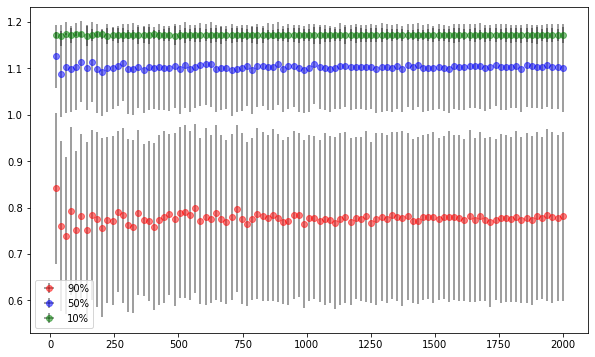

In [296]:
iteraciones = np.linspace(0,2000, 100)

info90 = np.zeros((len(iteraciones),2))
info50 = info90*0
info10 = info90*0

info90 = np.array([ DKs_bootstrap(mag2,porcentaje=0.9,iteraciones=int(i)) for i in iteraciones])
info50 = np.array([ DKs_bootstrap(mag2,porcentaje=0.5,iteraciones=int(i)) for i in iteraciones])
info10 = np.array([ DKs_bootstrap(mag2,porcentaje=0.1,iteraciones=int(i)) for i in iteraciones])

plt.figure(figsize=(10,6))
plt.errorbar(iteraciones, info90[:,0],info90[:,1],0,'or', label='90%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.errorbar(iteraciones, info50[:,0],info50[:,1],0,'ob', label='50%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.errorbar(iteraciones, info10[:,0],info10[:,1],0,'og', label='10%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.legend(loc='best')
#plt.xscale('log')
plt.show()

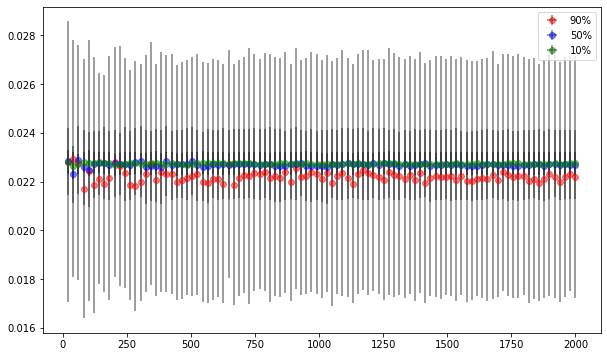

In [304]:
iteraciones = np.linspace(0,2000, 100)

funcion='asd'

#info90 = np.zeros((len(iteraciones),2))
#info50 = info90[:]
#info10 = info90[:]

info90 = np.array([ (bootstrap_index(mjd1,mag1,err1,funcion=funcion,porcentaje=0.9,iteraciones=int(i))) for i in iteraciones])
info50 = np.array([ (bootstrap_index(mjd1,mag1,err1,funcion=funcion,porcentaje=0.5,iteraciones=int(i))) for i in iteraciones])
info10 = np.array([ (bootstrap_index(mjd1,mag1,err1,funcion=funcion,porcentaje=0.1,iteraciones=int(i))) for i in iteraciones])

plt.figure(figsize=(10,6))
plt.errorbar(iteraciones, info90[:,0],info90[:,1],0,'or', label='90%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.errorbar(iteraciones, info50[:,0],info50[:,1],0,'ob', label='50%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.errorbar(iteraciones, info10[:,0],info10[:,1],0,'og', label='10%',linestyle='none', ecolor='black', alpha=0.5,capsize=0)
plt.legend(loc='best')
#plt.xscale('log')
plt.show()

In [36]:
path_catalogs = '/Users/nicomedinap/Documentos_locales/PhD_TESIS/Catalogos/' 

df = pd.read_csv(path_catalogs+'Irregular_catalog_SFR3_21Sep2021.csv', sep=',')
df_overplotted = pd.read_csv(path_catalogs+'/Irregular_catalog_SFR3_superposed_21Sep2021.csv', sep=',')

df.head()
df['mean_Ks'].size
#df_overplotted.head()

1825

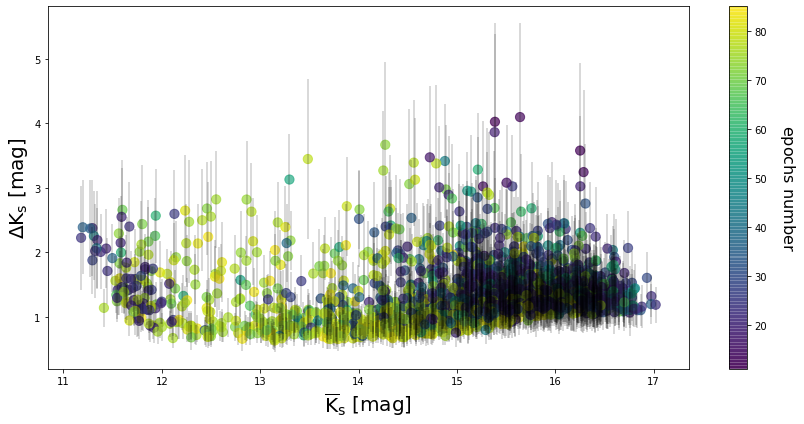

In [37]:
plt.figure(figsize=(12,6))

plt.errorbar(df['mean_Ks'], df['ampl'],df['devstd'],0,',', linestyle='none', ecolor='black', alpha=0.2,capsize=0, ms=0)
sc=plt.scatter(df['mean_Ks'],df['ampl'],c=df['epoch'], s=85, alpha=0.7)

fz=10
fontsize = 20

#legend
cbar = plt.colorbar(sc)
cbar.set_label(r'${ \rm epochs\ number }$', rotation=270, fontsize=16, labelpad=30)

plt.xlabel(r'${\rm \overline{K}_s\ [mag]}$',fontsize=fontsize)
plt.ylabel(r'${\rm \Delta K_{s}\ [mag] }$',fontsize=fontsize)
plt.xticks(fontsize=fz)
plt.yticks(fontsize=fz)

#plt.yscale('log')

plt.tight_layout()
#plt.savefig("BaelysDiagram.jpg", format='jpg',dpi=100)
plt.show()

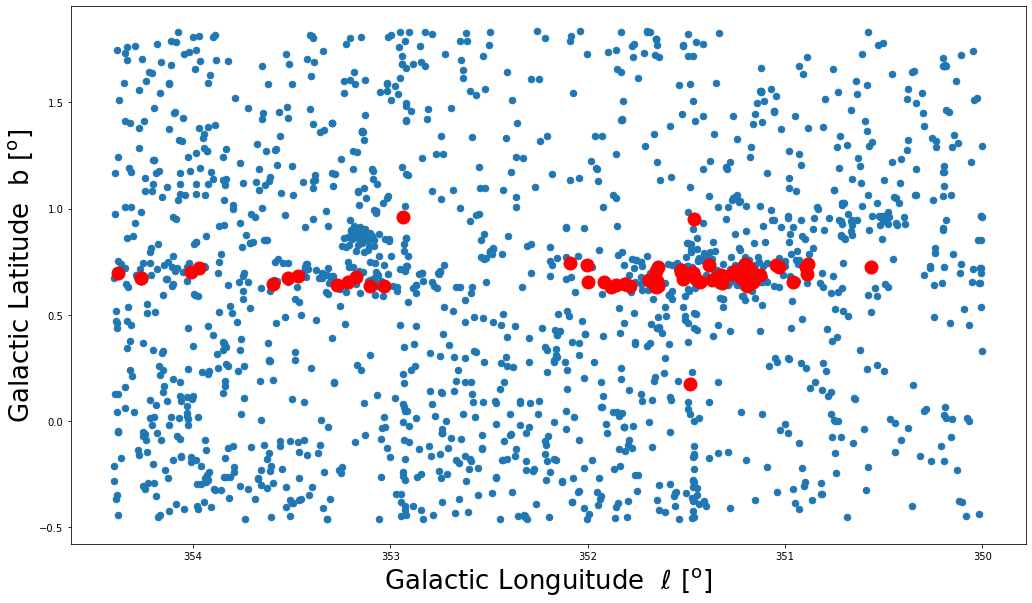

In [38]:
plt.figure(figsize=(14,8))

l,b = ReadCords(df['Ra'],df['Dec'],gal=True,Ndecimales=7)

l_over, b_over = ReadCords(df_overplotted['Ra_1'],df_overplotted['Dec_1'],gal=True,Ndecimales=7)

plt.plot(l,b,'.', ms=13)
plt.plot(l_over, b_over,'ro', ms=13)
plt.tight_layout()
plt.xlabel(r'${\rm Galactic\ Longuitude\ \ \ell\ [^{o}]}$',fontsize=26) 
plt.ylabel(r'${\rm Galactic\ Latitude\ \ b\ [^{o}]}$'     ,fontsize=26) 
plt.gca().invert_xaxis()
plt.show()

Alrededor de 1800 fuentes candidatas, y sobredensidades prometedoras. Ahora veremos la distribución de épocas de estas fuentes:

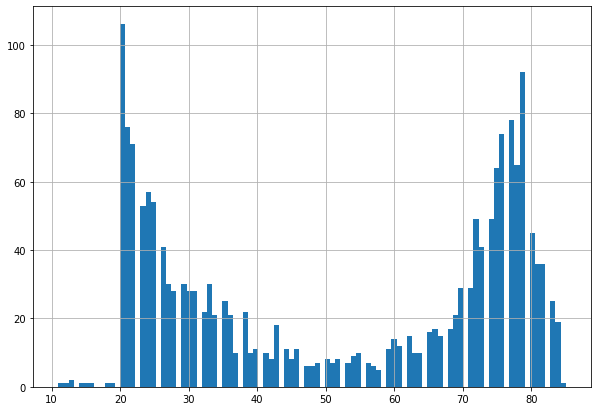

In [41]:
plt.figure(figsize=(10,7))
hist = df['epoch'].hist(bins=nbins(df['epoch']))

Existe una alta presencia de fuentes con bajo numero de observaciones, que parecieran tener un punto de inflexión en epochs=50. Haremos el corte en ese valor y volveremos a plotear la distribución espacial.  

In [61]:
highEpochNumber = df.loc[(df["epoch"] >= 50)]

highEpochNumber["epoch"].size

957

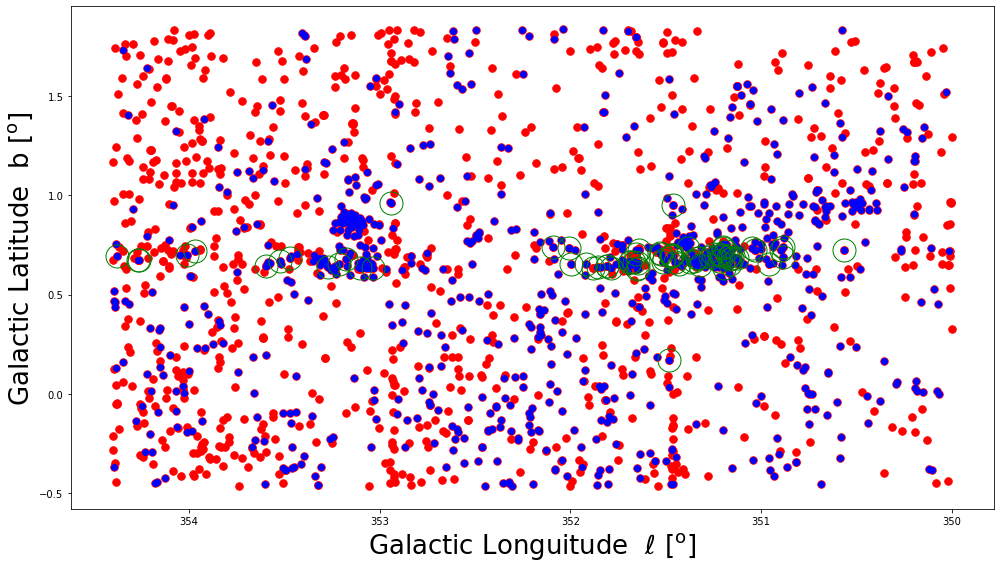

In [64]:
plt.figure(figsize=(14,8))

l_50,b_50 = ReadCords(highEpochNumber['Ra'],highEpochNumber['Dec'],gal=True,Ndecimales=7)

plt.plot(l,b,'r.', ms=15)
plt.plot(l_50,b_50,'b.', ms=12)
plt.plot(l_over, b_over,'go', ms=23, mfc='none')
plt.gca().invert_xaxis()
plt.xlabel(r'${\rm Galactic\ Longuitude\ \ \ell\ [^{o}]}$',fontsize=26) 
plt.ylabel(r'${\rm Galactic\ Latitude\ \ b\ [^{o}]}$'     ,fontsize=26) 
plt.tight_layout()
plt.show()

## Colores para las fuentes seleccionadas:

el query en SQL para el catálogo viva es el siguiente:

SELECT ra,dec,vivaID,JAperMag3, JAperMag3Err, HAperMag3, HAperMag3Err, KsAperMag3, KsAperMag3Err, aVar,EJKs, EJKsErr, bestPeriod
FROM vvvVivaCatalogue
WHERE ra BETWEEN 258.13321458 AND 263.33564802 AND dec BETWEEN -37.54970525 AND -32.71217792 

258.13321458 263.33564802
-37.54970525 -32.71217792


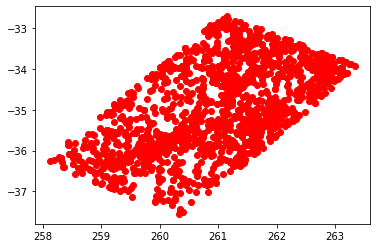

In [50]:
print(min(df['Ra']),max(df['Ra']))

print(min(df['Dec']),max(df['Dec']))


plt.plot(df['Ra'], df['Dec'], 'ro')

In [52]:
df_SFR3_VIVA = pd.read_csv(path_catalogs+'/SFR3_match_irregulars_VIVA.csv', sep=',')

df_SFR3_VIVA.head()

,Ra,Dec_1,catname,epoch,ampl,mean_Ks,meanerr,devstd,meanstd,Eta,...,JAperMag3Err,HAperMag3,HAperMag3Err,KsAperMag3,KsAperMag3Err,aVar,EJKs,EJKsErr,bestPeriod,Separation
0,260.019684,-37.046423,260.01968418-37.04642268.lc,73,3.670,14.271,0.075,1.283,11.125,0.077,...,-999999500.0,-9.999995e+08,-9.999995e+08,1.305856e+01,7.023000e-03,2.040539,2.737252,0.013484,0.998339,0.020383
1,260.980382,-36.297514,260.9803823-36.29751367.lc,75,3.271,14.251,0.056,0.927,15.367,0.049,...,-999999500.0,1.641738e+01,5.790500e-02,1.275590e+01,5.602000e-03,1.999403,2.555747,0.388183,581.000134,0.047635
2,260.289958,-36.514109,260.28995782-36.5141095.lc,71,2.977,14.888,0.060,1.003,14.836,0.271,...,-999999500.0,1.841163e+01,3.558840e-01,-9.999995e+08,-9.999995e+08,1.840801,2.472648,0.241061,508.140409,0.060007
3,260.807874,-36.838605,260.80787433-36.83860523.lc,75,2.823,12.552,0.046,0.751,16.714,0.188,...,-999999500.0,-9.999995e+08,-9.999995e+08,1.386897e+01,1.469500e-02,2.306639,2.931825,0.504353,546.645238,0.022163
4,259.804431,-36.340699,259.80443144-36.34069941.lc,67,2.690,15.381,0.055,0.877,17.529,0.302,...,-999999500.0,-9.999995e+08,-9.999995e+08,1.428012e+01,2.068000e-02,1.412101,2.638535,0.298121,0.998680,0.279924


In [66]:
largo = df_SFR3_VIVA['JAperMag3'].size


J_phot = np.array([ df_SFR3_VIVA['JAperMag3'].iloc[i] for i in range(largo) if (df_SFR3_VIVA['JAperMag3'].iloc[i]>0) \
                  and (df_SFR3_VIVA['HAperMag3'].iloc[i]>0) ])

H_phot = np.array([ df_SFR3_VIVA['HAperMag3'].iloc[i] for i in range(largo) if (df_SFR3_VIVA['JAperMag3'].iloc[i]>0) \
                  and (df_SFR3_VIVA['HAperMag3'].iloc[i]>0) ])

meanKs = np.array([ df_SFR3_VIVA['mean_Ks'].iloc[i] for i in range(largo) if (df_SFR3_VIVA['JAperMag3'].iloc[i]>0) \
                  and (df_SFR3_VIVA['HAperMag3'].iloc[i]>0) ])

RA = np.array([ df_SFR3_VIVA['Ra'].iloc[i] for i in range(largo) if (df_SFR3_VIVA['JAperMag3'].iloc[i]>0) \
                  and (df_SFR3_VIVA['HAperMag3'].iloc[i]>0) ])

DEC = np.array([ df_SFR3_VIVA['Dec_1'].iloc[i] for i in range(largo) if (df_SFR3_VIVA['JAperMag3'].iloc[i]>0) \
                  and (df_SFR3_VIVA['HAperMag3'].iloc[i]>0) ])

J_H = J_phot - H_phot
H_Ks = H_phot - meanKs

In [57]:
print(len(J_phot), len(H_phot), len(meanKs))

456 456 456


## Funcion para dibujar la linea en el CCD:

In [55]:
#Definimos la función para dibujar la línea:
def linea(x,y,plot=False,grid=100):
    
    import numpy as np
     
    # Calculate the coefficients. This line answers the initial question. 
    coefficients = np.polyfit(x, y, 1)

    #Print the findings
    #print 'a =', coefficients[0]
    #print 'b =', coefficients[1]

    # Let's compute the values of the line...
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(min(x),max(x),grid)
    y_axis = polynomial(x_axis)

    if plot==True:
        # ...and plot the points and the line
        plt.plot(x_axis, y_axis)
        plt.plot(x,y,'o',ms=15)
    
    return x_axis,y_axis,polynomial

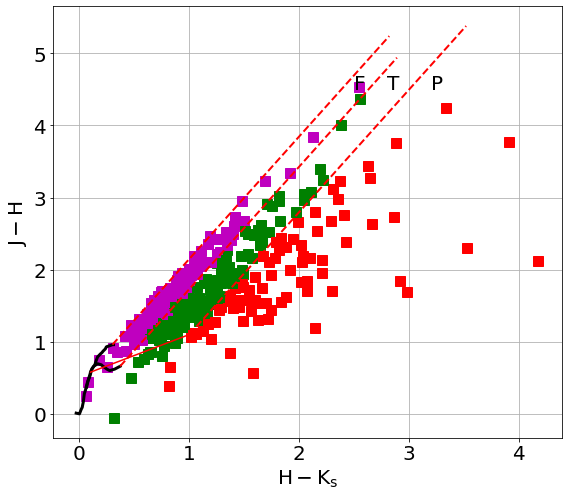

In [69]:
#Enrojecimiento tomando en cuenta Av=15 
Av = 40

#Rieke and Lebofsky 1985
E_JH = 0.107*Av
E_HKs = 0.063*Av

#Classical T tauri stars CTTS loci:
H_K_ctts = np.linspace(0.1,1,50) # grafico 1 del paper
J_H_ctts = 0.58*H_K_ctts+0.52
#plt.plot(H_K_ctts,J_H_ctts,'-',color='red')

CTTS_JHi = J_H_ctts[-1]
CTTS_HKi = H_K_ctts[-1]
CTTSJHe = CTTS_JHi + E_JH
CTTSHKe = CTTS_HKi + E_HKs
#vector enrojecimiento para enanas
#plt.plot([CTTS_HKi,CTTSHKe],[CTTS_JHi,CTTSJHe],'--',color='red',lw=2)

#Bessel Brett 1988
#Color for Dwarfs
DJ_H=[0.01, -0.0, 0.02,0.06,0.09,0.13,0.165,0.23,0.285,0.305,0.32,0.33,0.37,0.45,0.5,0.58,0.61,0.66,0.695,0.68,0.665,0.62,0.6,0.62,0.66]
DH_K=[-0.03,0.0,0.005,0.015,0.025,0.03,0.035,0.04,0.045,0.05,0.052,0.055,0.06,0.075,0.09,0.105,0.11,0.13,0.165,0.2,0.21,0.25,0.275,0.32,0.37]
#Color for Giants
GJ_H=[0.37,0.47,0.5,0.5,0.54,0.58,0.63,0.68,0.73,0.79,0.83,0.85,0.87,0.9,0.93,0.95,0.96,0.96]
GH_K=[0.065,0.08,0.085,0.085,0.095,0.1,0.115,0.14,0.15,0.165,0.19,0.205,0.215,0.235,0.245,0.285,0.3,0.31]

#estrellas del tipo enanas M6 con J-H=0.66, H-K=0.37 bessell 1988
JH_i = 0.66
HKs_i = 0.37
JHe = JH_i + E_JH
HKse = HKs_i + E_HKs
#vector enrojecimiento para enanas
#plt.plot([HKs_i,HKse],[JH_i,JHe],'--',color='red',lw=2)#,label='Reddening vector')

#Gigantes
#estrellas del tipo gigantes M6 con J-H=0.96, H-K=0.3 bessell 1988
JH_i2 = 0.96
HKs_i2 = 0.3
JHg = JH_i2 + E_JH
HKsg = HKs_i2 + E_HKs
#vector enrojecimiento para gigantes
#plt.plot([HKs_i2,HKsg],[JH_i2,JHg],'--',color='red',lw=2)

#vector enrojecimiento para gigantes
x,y,= [HKs_i2,HKsg],[JH_i2,JHg]
a,b,eq1 = linea(x,y)

#vector enrojecimiento para enanas
x,y = [HKs_i,HKse],[JH_i,JHe]
a,b,eq2 = linea(x,y)

#Classical T tauri stars CTTS loci:
x,y = [CTTS_HKi,CTTSHKe],[CTTS_JHi,CTTSJHe]
a,b,eq3 = linea(x,y)


plt.figure(figsize=(8,7))

#Ploteamos en densidad el campo de b343
gridsize=300
fontsize=20
ms=9 
cmap = plt.get_cmap('Blues')
#hb = plt.hexbin(H341-Ks341,J341-H341, gridsize=gridsize, bins="log",cmap=cmap)

#Evaluamos las ecuaciones construidas con la función linea con los colores H-Ks, estarán en Eq1,Eq2,Eq3
Eq1 = np.array([ eq1(H_Ks[i]) for i in range(len(H_Ks)) ])
Eq2 = np.array([ eq2(H_Ks[i]) for i in range(len(H_Ks)) ])
Eq3 = np.array([ eq3(H_Ks[i]) for i in range(len(H_Ks)) ])


f1 = open('CCM_locus_SFR3.cat','w')
f1.write('#IDs 		Ra	     	Dec	  		J-H   		H-Ks  		Class\n')


#print '#IDs 	Ra	     Dec	  J-H   H-Ks  Class'
for i in range(len(J_H)):
    
    ID = 'Irr_var_'+str(i)
        
    if Eq3[i] > J_H[i]:
        plt.plot(H_Ks[i],J_H[i],'sr',ms=10)#,label='P')
        #print(ID,RA[i],DEC[i],J_H[i],H_Ks[i],'P')
        f1.write("%s\t%f\t%f\t%f\t%f\t'P'\n" %(ID,RA[i],DEC[i],J_H[i],H_Ks[i]))
        
    elif Eq2[i] > J_H[i]:
        plt.plot(H_Ks[i],J_H[i],'sg',ms=10)#,label='T')
        #print(ID,RA[i],DEC[i],J_H[i],H_Ks[i],'T')
        f1.write("%s\t%f\t%f\t%f\t%f\t'T'\n" %(ID,RA[i],DEC[i],J_H[i],H_Ks[i]))

    elif Eq1[i] > J_H[i]:
        plt.plot(H_Ks[i],J_H[i],'sm',ms=10)#,label='F')
        #print(ID,RA[i],DEC[i],J_H[i],H_Ks[i],'F')
        f1.write("%s\t%f\t%f\t%f\t%f\t'F'\n" %(ID,RA[i],DEC[i],J_H[i],H_Ks[i]))
    f1.flush()
f1.close()

plt.plot(DH_K,DJ_H,'k-',lw=3)
plt.plot(GH_K,GJ_H,'k-',lw=3)

plt.xlabel(r'$\rm H-K_{s} $',fontsize=fontsize)
plt.ylabel(r"$\rm J-H $ ",fontsize=fontsize)

#vector enrojecimiento para enanas
plt.plot([HKs_i,HKse],[JH_i,JHe],'r--',lw=2)#,label='Reddening vector')
#vector enrojecimiento para lgigantes
plt.plot([HKs_i2,HKsg],[JH_i2,JHg],'r--',lw=2)

#Classical T tauri stars CTTS loci:
H_K_ctts = np.linspace(0.1,1,50) # grafico 1 del paper
J_H_ctts = 0.58*H_K_ctts+0.52
plt.plot(H_K_ctts,J_H_ctts,'-',color='red')
plt.plot([CTTS_HKi,CTTSHKe],[CTTS_JHi,CTTSJHe],'r--',lw=2)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(which='both')  
plt.text(2.5, 4.5, 'F',color='black',fontsize=fontsize)
plt.text(2.8, 4.5, 'T',color='black',fontsize=fontsize)
plt.text(3.2, 4.5, 'P',color='black',fontsize=fontsize)

#plt.xlim(-0.4,3.6)
#plt.ylim(-0.2,5)
#plt.legend(loc='best')

plt.tight_layout()

#plt.savefig('CCM_selection.jpg')
plt.show()

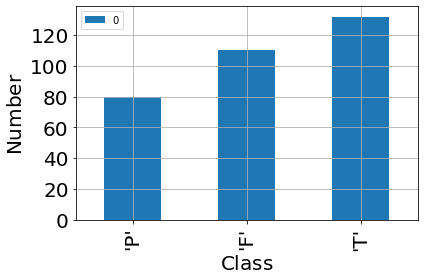

In [74]:
import pandas
from collections import Counter

ColorClass = np.genfromtxt('CCM_locus_SFR3.cat',usecols=5,dtype=str)

letter_counts = Counter(ColorClass)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(which='both') 
plt.xlabel(r'$\rm Class$',fontsize=fontsize)
plt.ylabel(r"$\rm Number$ ",fontsize=fontsize)
plt.tight_layout()
#plt.savefig('Number_of_each_category.png')
plt.show()

## Visualizar series de tiempo superpuestas:

existen 75 fuentes que fueron observadas e indentificadas por separado por el mismo método y diferentes tiles. Primero haremos algunas comparaciones básicas, como amplitud, magnitud promedio e índice eta:


In [67]:
df_overplotted = pd.read_csv(path_catalogs+'/Irregular_catalog_SFR3_superposed_21Sep2021.csv', sep=',')

df_overplotted['mean_Ks_1'].size

df_overplotted.head()

#df_overplotted.head()

,Ra_1,Dec_1,catname_1,epoch_1,ampl_1,mean_Ks_1,meanerr_1,devstd_1,meanstd_1,Eta_1,...,devstd_2,meanstd_2,Eta_2,J_2,K_2,logchi2_2,kurt_2,skewness_2,tileID_2,Separation
0,261.894510,-33.631688,261.8945103-33.63168788.lc,62,2.191,14.808,0.042,0.655,22.615,0.373,...,0.618,24.314,0.566,5.023,0.857,4.113,8738.995,-302.896,b343,0.146415
1,261.349514,-34.456369,261.34951386-34.45636905.lc,72,2.106,16.237,0.025,0.394,41.223,0.695,...,0.500,32.360,0.718,2.792,0.724,3.518,5663.782,-355.182,b343,0.285483
2,261.455182,-34.296707,261.4551824-34.2967073.lc,76,1.654,15.481,0.025,0.424,36.549,0.870,...,0.521,29.936,0.544,4.399,0.862,3.941,6023.715,-189.750,b343,0.087457
3,261.404152,-34.313533,261.40415233-34.31353325.lc,77,1.578,14.882,0.023,0.406,36.623,0.585,...,0.354,41.969,0.639,3.026,0.805,3.360,2245.104,-67.613,b343,0.028725
4,261.396527,-34.399949,261.3965266-34.39994898.lc,76,1.538,15.520,0.025,0.416,37.342,0.837,...,0.320,48.653,0.650,2.515,0.833,2.885,726.262,-5.729,b343,0.301681


Ahora, es necesario visualizar las fuentes juntando las series de tiempo de estrellas overplotted:

261.8945103-33.63168788.lc


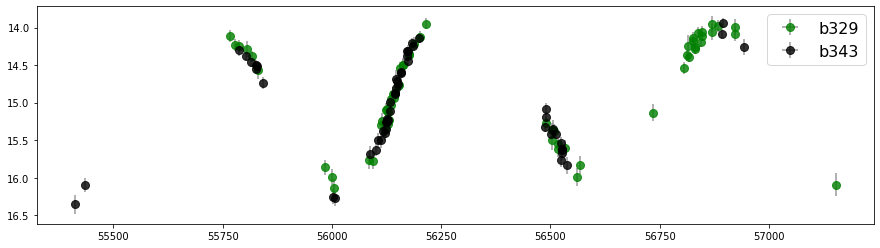

261.34951386-34.45636905.lc


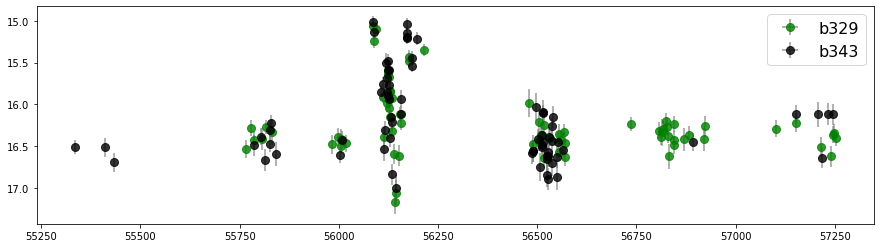

261.4551824-34.2967073.lc


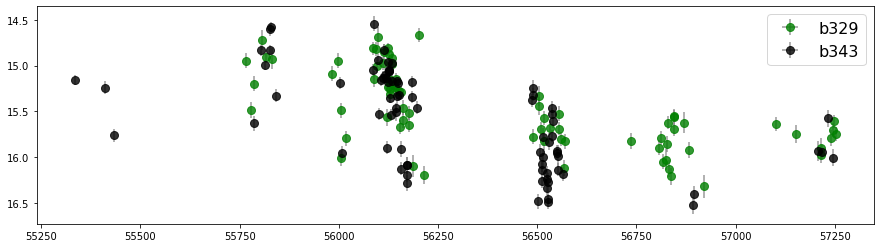

261.40415233-34.31353325.lc


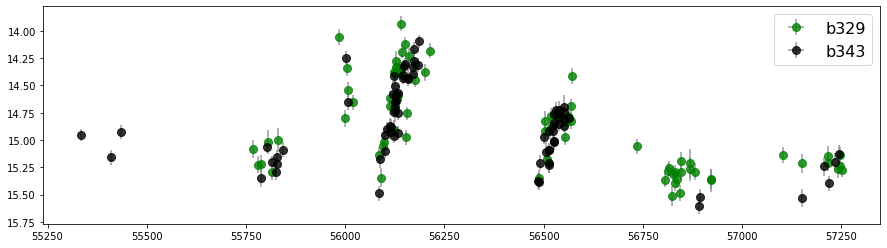

261.3965266-34.39994898.lc


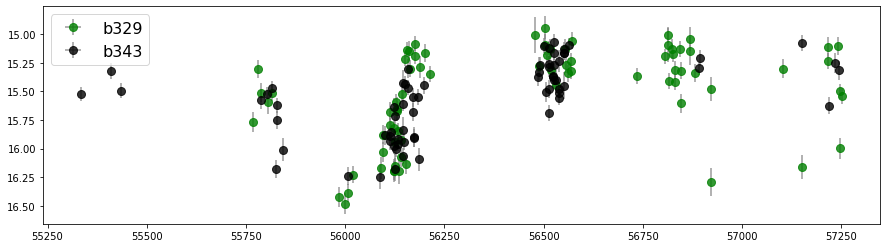

262.19363301-33.30472457.lc


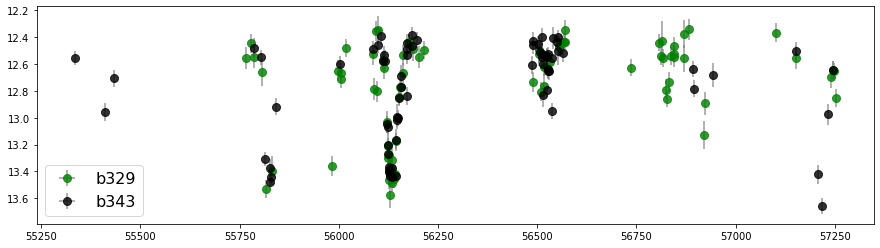

261.59738578-34.06771713.lc


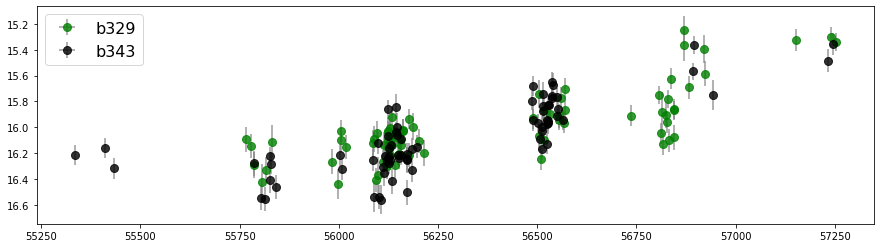

261.50666518-34.25412733.lc


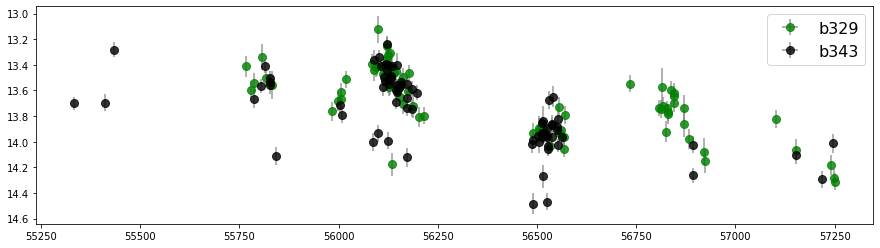

261.64298661-34.03194221.lc


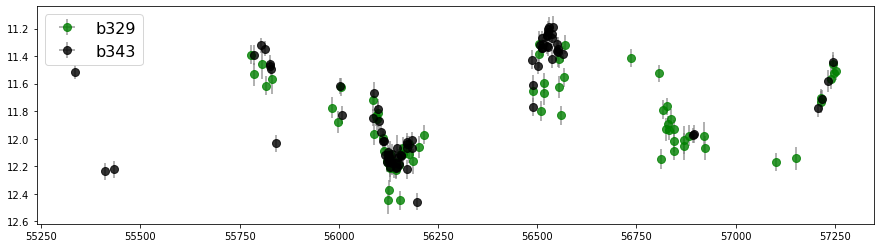

262.13796845-33.4127483.lc


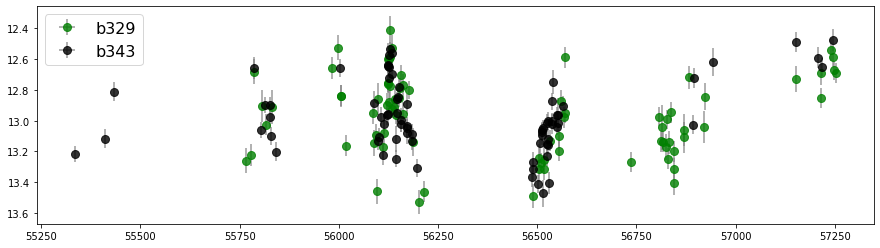

In [27]:
#for i in range(df_overplotted['mean_Ks_1'].size):
for i in range(0,10):
    cat_1, cat_2 = df_overplotted['catname_1'].iloc[i],df_overplotted['catname_2'].iloc[i]
    tileID1, tileID2 = df_overplotted['tileID_1'].iloc[i],df_overplotted['tileID_2'].iloc[i]
    
    #los datos a los tiles tienes diferentes caminos, así que hay que especificarlos:
    
    if tileID1 == 'b310' or tileID1 =='b343':
        path_1='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID1+'_data/Amplitude_Candidates/'
    else:
        path_1='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID1+'_data/Amplitude_Candidates/'
        
    if tileID2 == 'b310' or tileID2 =='b343':
        path_2='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID2+'_data/Amplitude_Candidates/'
    else:
        path_2='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID2+'_data/Amplitude_Candidates/'
    
    lc1 = np.genfromtxt(path_1+cat_1)
    mjd1, mag1, err1 = lc1[:,0], lc1[:,1], lc1[:,2]
    
    lc2 = np.genfromtxt(path_2+cat_2)
    mjd2, mag2, err2 = lc2[:,0], lc2[:,1], lc2[:,2]
    
    print(cat_1)
    
    plt.figure(figsize=(15,4))
    plt.errorbar(mjd1, mag1, err1,0, 'go', ecolor='gray', label=tileID1, alpha=0.8, ms=8)
    plt.errorbar(mjd2, mag2, err2,0, 'ko', ecolor='gray', label=tileID2, alpha=0.8, ms=8)
    plt.gca().invert_yaxis()
    plt.legend(loc='best',fontsize=fz)
    plt.show()



## Calculamos los indices independientemente para ambos sets de series de tiempo:

In [260]:
f = open("asd.txt", "w")
f.write("#Ra		Dec		TileID1	Catname1			Epoch1	MeanKs1	dMean1	DKs1	DKserr1	eta1	deta1	J1	dJ1	K1	dK1	chi2_1	dchi2_1	ratio1	dratio1	TileID2	Catname2			Epoch2	MeanKs2	dMean2	DKs2		DKserr2	eta2	deta2	J2	dJ2	K2	dK2	chi2_2	dchi2_2	ratio2	dratio2	Separación\n")

for i in range(df_overplotted['mean_Ks_1'].size):
    
    separacion = df_overplotted['Separation'].iloc[i]
    
    catname_1, catname_2 = df_overplotted['catname_1'].iloc[i],df_overplotted['catname_2'].iloc[i]
    tileID_1, tileID_2 = df_overplotted['tileID_1'].iloc[i],df_overplotted['tileID_2'].iloc[i]
    
    #Guardamos las coordenadas del primer tile:
    Ra,Dec = df_overplotted['Ra_1'].iloc[i],df_overplotted['Dec_2'].iloc[i]
    
    #los datos a los tiles tienes diferentes caminos, así que hay que especificarlos:
    
    if tileID_1 == 'b310' or tileID_1 =='b343':
        path_1='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID_1+'_data/Amplitude_Candidates/'
    else:
        path_1='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID_1+'_data/Amplitude_Candidates/'
        
    if tileID_2 == 'b310' or tileID_2 =='b343':
        path_2='/Users/nicomedinap/Documentos_locales/PhD_TESIS/VVV_data/'+tileID_2+'_data/Amplitude_Candidates/'
    else:
        path_2='/Volumes/TOSHIBA3TBs/GRUPO_CIUDADANO/'+tileID_2+'_data/Amplitude_Candidates/'
    
    lc1 = np.genfromtxt(path_1+catname_1)
    mjd1, mag1, err1 = lc1[:,0], lc1[:,1], lc1[:,2]
    
    epochs_1 = len(mjd1)
    eta_1, deta_1 = bootstrap_index(mjd1,mag1,err1,funcion='eta',porcentaje=0.5,show_hist=False)
    J_1, dJ_1 = bootstrap_index(mjd1,mag1,err1,funcion='StetsonJ',porcentaje=0.5,show_hist=False)
    K_1, dK_1 = bootstrap_index(mjd1,mag1,err1,funcion='StetsonK',porcentaje=0.5,show_hist=False)
    chi2_1, dchi2_1 = bootstrap_index(mjd1,mag1,err1,funcion='logChi2',porcentaje=0.5,show_hist=False)
    ratio_1, dratio_1 = bootstrap_index(mjd1,mag1,err1,funcion='mu_sigma_ratio',porcentaje=0.5,show_hist=False)
    DKs_1, DKserr_1 = DKs_bootstrap(mag1,porcentaje=0.5,show_hist=False)
    MeanKs_1, dMeanKserr_1 = MeanKs_bootstrap(mag1,porcentaje=0.5, show_hist=False)
    
    
    lc2 = np.genfromtxt(path_2+catname_2)
    mjd2, mag2, err2 = lc2[:,0], lc2[:,1], lc2[:,2]
    
    epochs_2 = len(mjd2)
    eta_2, deta_2 = bootstrap_index(mjd2,mag2,err2,funcion='eta',porcentaje=0.5,show_hist=False)
    J_2, dJ_2 = bootstrap_index(mjd2,mag2,err2,funcion='StetsonJ',porcentaje=0.5,show_hist=False)
    K_2, dK_2 = bootstrap_index(mjd2,mag2,err2,funcion='StetsonK',porcentaje=0.5,show_hist=False)
    chi2_2, dchi2_2 = bootstrap_index(mjd2,mag2,err2,funcion='logChi2',porcentaje=0.5,show_hist=False)
    ratio_2, dratio_2 = bootstrap_index(mjd2,mag2,err2,funcion='mu_sigma_ratio',porcentaje=0.5,show_hist=False)
    DKs_2, DKserr_2 = DKs_bootstrap(mag2,porcentaje=0.5,show_hist=False)
    MeanKs_2, dMeanKserr_2 = MeanKs_bootstrap(mag2,porcentaje=0.5, show_hist=False)


    f.write("%0.7f\t%0.7f\t%s\t%s\t%g\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%s\t%s\t%g\t%.3f\t%.3f\t%.3f \
    \t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\n" \
           %(Ra,Dec,tileID_1,catname_1,epochs_1,MeanKs_1,dMeanKserr_1,DKs_1,DKserr_1,eta_1,deta_1,J_1,dJ_1,K_1,dK_1,chi2_1,dchi2_1,ratio_1, \
    dratio_1,tileID_2,catname_2,epochs_2,MeanKs_2,dMeanKserr_2,DKs_2,DKserr_2,eta_2,deta_2,J_2,dJ_2,K_2,dK_2,chi2_2,dchi2_2,ratio_2,dratio_2,separacion))
    
    f.flush()
f.close()

## Leemos el archivo que acabamos de crear para hacer las regresiones lineales entre índices:
Habría que estimar la correlacion de la amplitud usando una regresión lineal para poder comparar. Agregar todos los índices y sus incertezas para graficar todos los resultados en un plot de regresión lineal :D

In [10]:
df_indices = pd.read_csv(path_catalogs+'variability_indices_match_between_tiles_SFR3.csv', sep=',')

print(df_indices['Ra'].size)

df_indices.head()

#df_overplotted.head()

75


,Ra,Dec,TileID1,Catname1,Epoch1,MeanKs1,dMean1,DKs1,DKserr1,eta1,...,deta2,J2,dJ2,K2,dK2,chi2_2,dchi2_2,ratio2,dratio2,Separacion
0,261.894510,-33.631677,b329,261.8945103-33.63168788.lc,62,14.808,0.085,2.122,0.084,0.682,...,0.163,2.668,0.727,0.876,0.021,4.100,0.151,0.041,0.003,0.146
1,261.349514,-34.456314,b329,261.34951386-34.45636905.lc,72,16.237,0.049,1.879,0.243,1.218,...,0.209,1.833,0.473,0.837,0.031,3.489,0.204,0.031,0.003,0.285
2,261.455182,-34.296701,b329,261.4551824-34.2967073.lc,76,15.482,0.050,1.558,0.091,0.929,...,0.161,2.053,0.440,0.858,0.020,3.932,0.122,0.033,0.002,0.087
3,261.404152,-34.313536,b329,261.40415233-34.31353325.lc,77,14.886,0.046,1.460,0.109,0.761,...,0.185,1.316,0.284,0.814,0.023,3.349,0.146,0.024,0.002,0.029
4,261.396527,-34.399964,b329,261.3965266-34.39994898.lc,76,15.519,0.050,1.450,0.086,0.915,...,0.173,0.969,0.285,0.820,0.025,2.872,0.139,0.020,0.001,0.302


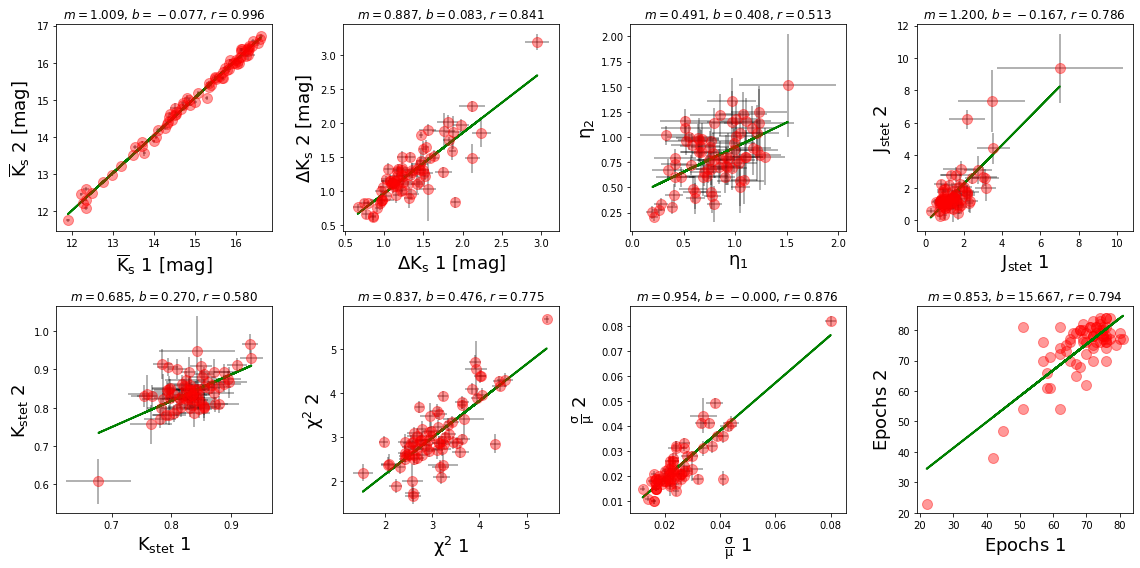

In [44]:
plt.figure(figsize=(16,8))

parametros = np.zeros((8,2))

fz=18

plt.subplot(241)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['MeanKs1'], df_indices['MeanKs2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['MeanKs1'] + inter
delta = df_indices['MeanKs2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['MeanKs1']))
#plt.title("$m=%0.3f$, $b=%0.3f$, $\sigma_{err}=%0.3f$ " %(slope,inter,std_err),loc='center', fontsize=fz-6)
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)

plt.errorbar(df_indices['MeanKs1'],df_indices['MeanKs2'],df_indices['dMean1'],df_indices['dMean2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['MeanKs1'],line,'g-',lw=2)

plt.xlabel(r'${\rm \overline{K}_s \ 1 \ [mag]}$',fontsize=fz) 
plt.ylabel(r'${\rm \overline{K}_s \ 2 \ [mag]}$',fontsize=fz) 

#guardamos los valores:
parametros[0] = slope,r

#-----

plt.subplot(242)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['DKs1'], df_indices['DKs2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['DKs1'] + inter
delta = df_indices['DKs2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['DKs1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['DKs1'],df_indices['DKs2'],df_indices['DKserr1'],df_indices['DKserr2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['DKs1'],line,'g-',lw=2)

plt.xlabel(r'${\rm \Delta K_{s}\ 1\ [mag]}$',fontsize=fz) 
plt.ylabel(r'${\rm \Delta K_{s}\ 2\ [mag]}$',fontsize=fz) 

#guardamos los valores:
parametros[1] = slope,r
#-----

plt.subplot(243)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['eta1'], df_indices['eta2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['eta1'] + inter
delta = df_indices['eta2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['eta1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['eta1'],df_indices['eta2'],df_indices['deta1'],df_indices['deta2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['eta1'],line,'g-',lw=2)

plt.xlabel(r'${\rm \eta_1 }$',fontsize=fz) 
plt.ylabel(r'${\rm \eta_2 }$',fontsize=fz) 

#guardamos los valores:
parametros[2] = slope,r
#-----

plt.subplot(244)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['J1'], df_indices['J2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['J1'] + inter
delta = df_indices['J2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['J1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['J1'],df_indices['J2'],df_indices['dJ1'],df_indices['dJ2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['J1'],line,'g-',lw=2)

plt.xlabel(r'${\rm J_{stet}\ 1 }$',fontsize=fz) 
plt.ylabel(r'${\rm J_{stet}\ 2 }$',fontsize=fz) 

#guardamos los valores:
parametros[3] = slope,r
#-----

plt.subplot(245)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['K1'], df_indices['K2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['K1'] + inter
delta = df_indices['K2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['K1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['K1'],df_indices['K2'],df_indices['dK1'],df_indices['dK2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['K1'],line,'g-',lw=2)

plt.xlabel(r'${\rm K_{stet}\ 1 }$',fontsize=fz) 
plt.ylabel(r'${\rm K_{stet}\ 2 }$',fontsize=fz) 

#guardamos los valores:
parametros[4] = slope,r
#-----

plt.subplot(246)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['chi2_1'], df_indices['chi2_2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['chi2_1'] + inter
delta = df_indices['chi2_2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['chi2_1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['chi2_1'],df_indices['chi2_2'],df_indices['dchi2_1'],df_indices['dchi2_2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['chi2_1'],line,'g-',lw=2)

plt.xlabel(r'${\rm \chi^2\ 1}$',fontsize=fz) 
plt.ylabel(r'${\rm \chi^2\ 2}$',fontsize=fz) 

#guardamos los valores:
parametros[5] = slope,r
#-----

plt.subplot(247)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['ratio1'], df_indices['ratio2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['ratio1'] + inter
delta = df_indices['ratio2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['ratio1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.errorbar(df_indices['ratio1'],df_indices['ratio2'],df_indices['dratio1'],df_indices['dratio2'], \
             'or', linestyle='none', ecolor='black', alpha=0.4,capsize=0, ms=10)

plt.plot(df_indices['ratio1'],line,'g-',lw=2)

plt.xlabel(r'${\rm \frac{\sigma}{\mu}\ 1}$',fontsize=fz) 
plt.ylabel(r'${\rm \frac{\sigma}{\mu}\ 2}$',fontsize=fz) 

#guardamos los valores:
parametros[6] = slope,r
#-----

plt.subplot(248)

# Unweighted fit
slope, inter, r, p, std = stats.linregress((df_indices['Epoch1'], df_indices['Epoch2']))
r_sqr=r**2
# Standard error of the fit:
line = slope*df_indices['Epoch1'] + inter
delta = df_indices['Epoch2'] - line
sqr_sum_res = sum((delta)**2) # Squared sum of the residuals
std_err = np.sqrt(sqr_sum_res/len(df_indices['Epoch1']))
plt.title("$m=%0.3f$, $b=%0.3f$, $r=%0.3f$ " %(slope,inter,r),loc='center', fontsize=fz-6)


plt.plot(df_indices['Epoch1'],df_indices['Epoch2'],'or', alpha=0.4, ms=10)

plt.plot(df_indices['Epoch1'],line,'g-',lw=2)

plt.xlabel(r'${\rm Epochs\ 1}$',fontsize=fz) 
plt.ylabel(r'${\rm Epochs\ 2}$',fontsize=fz) 

#guardamos los valores:
parametros[7] = slope,r

plt.tight_layout()
plt.show()

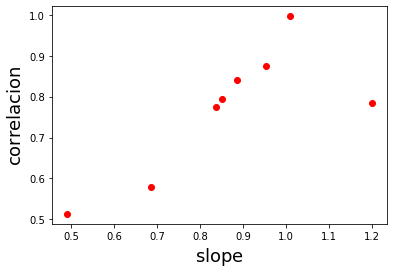

In [46]:
plt.plot(parametros[:,0], parametros[:,1],'ro')

plt.xlabel(r'${\rm slope }$',fontsize=fz) 
plt.ylabel(r'${\rm correlacion}$',fontsize=fz) 

plt.show()